In [4]:
import numpy as np
import sys
import csv
import matplotlib as mpl
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import os
sys.path.insert(1, str( (Path().absolute())  ) + "/src")

from parameters import occ_for_power, power_large_ref, power_SMR_ref, power_micro_ref, OM_cost_per_MWh, fuel_cycle_length, refueling_duration_estimate
from parameters import OCC_large_conservative_FOAK, OCC_SMR_conservative_FOAK, OCC_mico_conservative_FOAK, OM_large_hi,  OM_SMR_hi, OM_Mirco_hi
from parameters import cons_duration_large_conservative, cons_duration_SMR_conservative, cons_duration_micro_conservative
from economic_FOMs import tot_TCI_multiple_reactors
from schedule_similar_reactors import num_reactors_needed_for_capacity_factor_weeks_apprioach,  capacity_factor_weeks_approach
from economic_FOMs import level_cost_of_energy
from parameters import construction_duration_for_power


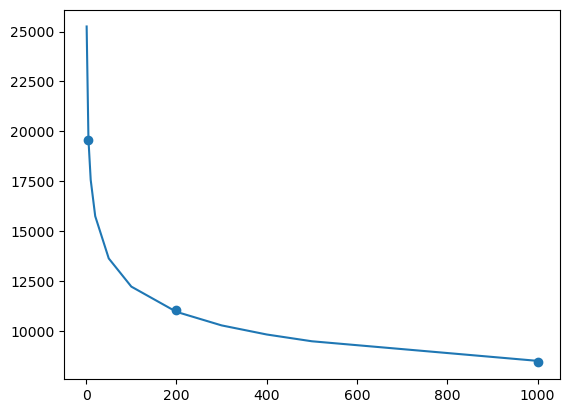

In [5]:
power_list = [1000, 500, 400, 300, 200, 100, 50, 20, 10, 5, 1]
ref_power = [power_large_ref, power_SMR_ref, power_micro_ref]
ref_cost = [OCC_large_conservative_FOAK, OCC_SMR_conservative_FOAK, OCC_mico_conservative_FOAK]


OCC_list =[]

for p in power_list :
    occ1 =occ_for_power(p)
    OCC_list .append(occ1)
    
plt.plot(power_list , OCC_list )  
plt.scatter(ref_power  , ref_cost )    
  
  

Text(0, 0.5, 'O&M Cost ($/MWhour)')

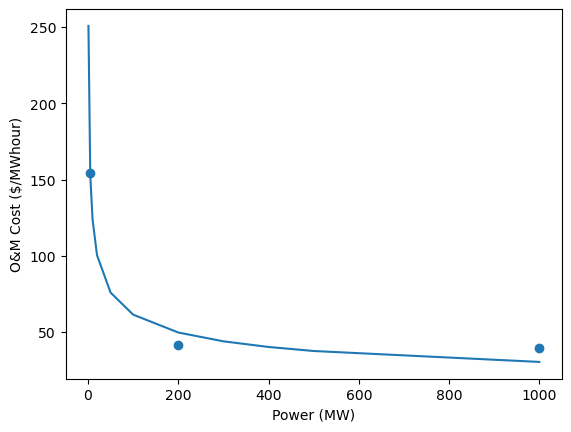

In [6]:
power_list = [1000, 500, 400, 300, 200, 100, 50, 20, 10, 5, 1]
ref_power = [power_large_ref, power_SMR_ref, power_micro_ref]
ref_cost_OM = [OM_large_hi,  OM_SMR_hi, OM_Mirco_hi]


OM_list =[]

for p in power_list :
    om1 = OM_cost_per_MWh(p)
    OM_list .append(om1)

OM_list_ref =[]


    
plt.plot(power_list , OM_list  )  
plt.scatter(ref_power ,ref_cost_OM  ) 
plt.xlabel("Power (MW)")
plt.ylabel("O&M Cost ($/MWhour)")

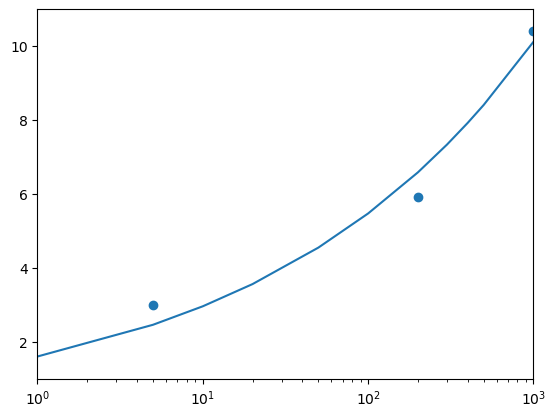

In [46]:
power_list = [1000, 500, 400, 300, 200, 100, 50, 20, 10, 5, 1]
ref_power = [power_large_ref, power_SMR_ref, power_micro_ref]
ref_cons = [cons_duration_large_conservative, cons_duration_SMR_conservative, cons_duration_micro_conservative] # in months


cons_duration_list =[]

for p in power_list :
    cd1 = construction_duration_for_power(p)
    cons_duration_list.append(cd1 )
 
plt.plot(power_list ,  np.array(cons_duration_list)/12  )  
plt.scatter(ref_power , np.array(ref_cons)/12 ) 
plt.xscale('log')
plt.xlim([1, 1000])
plt.ylim([1, 11])
plt.show()





# TCI

In [47]:
interest_rate = 0.06

print("Total TCIs for large, small, microreactors are : " , np.round(tot_TCI_multiple_reactors( power_large_ref, interest_rate, 1)/1000000000, 2),\
    np.round(tot_TCI_multiple_reactors( power_SMR_ref, interest_rate, 1)/1000000000, 2), np.round(tot_TCI_multiple_reactors(power_micro_ref , interest_rate, 1)/1000000000, 2), "USD (billions)" )

Total TCIs for large, small, microreactors are :  11.51 2.66 0.11 USD (billions)


In [48]:
# Electricity Prices
# According to: https://www.eia.gov/electricity/monthly/epm_table_grapher.php?t=epmt_5_6_a
# The US total cost of electircy in Apri 2023 is 12.18 cents / kwh and the minimum was 7.59 (dakota)
elec_price_tot = 121.8   # dollar /MWh
elec_price_min = 75.8   # dollar /MWh

# TCI for target demand and reliability

1000 Baseline
1000 0.9
1000 0.95
1000 0.99
1000 0.99999
1000 1


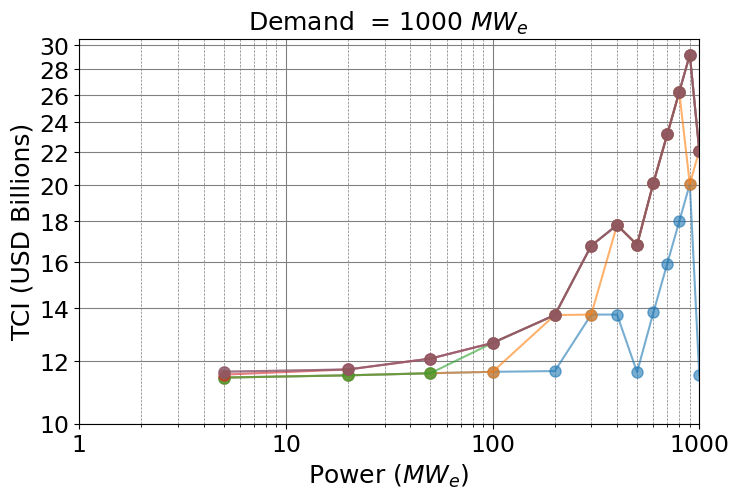

In [50]:
import matplotlib as mpl

# delete the output file is exists
filename = "TCI_for_demand_reliability.csv"
try:
    os.remove(filename)
except OSError:
    pass
    
power_list = [1000, 900 , 800, 700, 600, 500, 400, 300, 200, 100  ,50,  20, 5]# , 1]
min_capacity_factor_criteria_list = ['Baseline' ,0.9, 0.95,  0.99, 0.99999, 1]
interest_rate = 0.06
levelization_period_0 = int(365 * 30/7)
overall_capacity_factor_criteria = 0 # has no effect



for tot_demand in [1000]: #, 3000, 6000] :
    fig = plt.figure(figsize=(8, 5))
    plt.title( f"Demand  = {tot_demand} $MW_e$ ",  fontsize=18)
    for min_capacity_factor_criteria in min_capacity_factor_criteria_list:
        tot_TCI_list = []

        print(tot_demand, min_capacity_factor_criteria)
        for reactor_power in power_list:

            fuel_lifetime = fuel_cycle_length(reactor_power) 
            refueling_period =  refueling_duration_estimate(reactor_power) 
            
            if min_capacity_factor_criteria == "Baseline":
               num_reactors_needed = int(np.ceil(num_reactors_needed_for_capacity_factor_weeks_apprioach(overall_capacity_factor_criteria,\
                            0, fuel_lifetime, refueling_period, reactor_power ,\
                                levelization_period_0, tot_demand))) 
            else:
            
                num_reactors_needed = int(np.ceil(num_reactors_needed_for_capacity_factor_weeks_apprioach(overall_capacity_factor_criteria,\
                            min_capacity_factor_criteria, fuel_lifetime, refueling_period, reactor_power ,\
                                levelization_period_0, tot_demand)))

            tot_TCI = (tot_TCI_multiple_reactors (reactor_power, interest_rate, num_reactors_needed)) / 1000000000
            tot_TCI_list.append(tot_TCI)
        
        # save it into a list
        df1 = pd.DataFrame(tot_TCI_list)
        df1.to_csv(filename , mode='a',index = False)
        
        if min_capacity_factor_criteria == "Baseline" :
            plt.plot(power_list , tot_TCI_list , '-o' , markersize = 8,  alpha=0.6 ,label = "Baseline")
        else:
            plt.plot(power_list , tot_TCI_list , '-o' , markersize = 8,  alpha=0.6 ,label = f"Target Daily Agg. Capacity Factor = { min_capacity_factor_criteria}")

           
        plt.yscale('log')
        plt.xscale('log')
    if tot_demand == 500:
        plt.legend(bbox_to_anchor=(0.5, 1.5), loc='upper center', fontsize=17 , ncol=3)


    
    plt.grid(which='major', color='grey', linewidth=0.8)
    plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
    plt.minorticks_on() 
    
    # 
    # plt.gca().yaxis.set_minor_locator(plt.FixedLocator([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]))
    # plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter(''))
    # ax.xaxis.set_major_formatter(FormatStrFormatter('% 1.2f')) 
    plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    
    plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.gca().xaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    
    ticks_list = np.linspace( 2*np.floor((min(tot_TCI_list))/2)    , 2*np.ceil((max(tot_TCI_list))/2), int(1    +    np.ceil((max(tot_TCI_list))/2)   -    np.floor((min(tot_TCI_list))/2)   )  )
    plt.yticks( ticks_list)
    
    plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    plt.gca().xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
   
    
    # plt.gca().yaxis.set_major_locator(plt.MultipleLocator(2))
    
    plt.xlabel('Power ($MW_e$)', fontsize=18)
    plt.ylabel('TCI (USD Billions)', fontsize=18) 
    # plt.ylim(0,  10*np.ceil(max(tot_TCI_list)/10)          )
    plt.xlim( 1, 1000)
    
    plt.yticks(fontsize=17)
    plt.xticks(fontsize=17) 
    plt.savefig(f'TCI_{tot_demand}.png', bbox_inches='tight')
    plt.show()

# LCOE  = f (power, reliability and demand)

In [51]:


# delete the output file is exists
filename = "LCOE_for_demand_reliability.csv"
try:
    os.remove(filename)
except OSError:
    pass
    
power_list = [1000, 900 , 800, 700, 600, 500, 400, 300, 200, 100  ,50,  20, 5] # 1
min_capacity_factor_criteria_list = ['Baseline' ,0.9, 0.95,  0.99, 0.99999, 1]
interest_rate = 0.06
levelization_period_0 = int(365 * 30/7)
overall_capacity_factor_criteria = 0 # has no effect



for tot_demand in  [1000]: #, 6000] :
    
    demand_tot_lcoe_no_sell_list = []
    demand_tot_lcoe_sell_list = []
    
    for min_capacity_factor_criteria in min_capacity_factor_criteria_list:
        tot_lcoe_no_sell_list = []
        tot_lcoe_with_sell_list = []

        print(tot_demand, min_capacity_factor_criteria)
        for reactor_power in power_list:

            fuel_lifetime = fuel_cycle_length(reactor_power) 
            refueling_period =  refueling_duration_estimate(reactor_power) 
            
            if min_capacity_factor_criteria == "Baseline":
               num_reactors_needed = int(np.ceil(num_reactors_needed_for_capacity_factor_weeks_apprioach(overall_capacity_factor_criteria,\
                            0, fuel_lifetime, refueling_period, reactor_power ,\
                                levelization_period_0, tot_demand))) 
            else:
            
                num_reactors_needed = int(np.ceil(num_reactors_needed_for_capacity_factor_weeks_apprioach(overall_capacity_factor_criteria,\
                            min_capacity_factor_criteria, fuel_lifetime, refueling_period, reactor_power ,\
                                levelization_period_0, tot_demand)))
            
            results = capacity_factor_weeks_approach(fuel_lifetime, refueling_period, num_reactors_needed, reactor_power, levelization_period_0, tot_demand)
            Tot_MWh_generated_per_year_list = results[3]
            MWh_generated_per_year_per_demand_list = results[4]
            MWh_excess_per_year_list = results[5]
           
            # LCOE with and without selling electricity
            lcoe_no_sell = level_cost_of_energy( interest_rate, reactor_power, num_reactors_needed, Tot_MWh_generated_per_year_list,MWh_generated_per_year_per_demand_list, MWh_excess_per_year_list, 0)
            lcoe_with_sell = level_cost_of_energy( interest_rate, reactor_power, num_reactors_needed, Tot_MWh_generated_per_year_list,MWh_generated_per_year_per_demand_list, MWh_excess_per_year_list, elec_price_min)
            tot_lcoe_no_sell_list.append(lcoe_no_sell)
            tot_lcoe_with_sell_list.append(lcoe_with_sell )

        demand_tot_lcoe_no_sell_list.append(tot_lcoe_no_sell_list)
        demand_tot_lcoe_sell_list.append(tot_lcoe_with_sell_list)
    
    if tot_demand == 500: 
          demand_tot_lcoe_no_sell_list_500 = demand_tot_lcoe_no_sell_list 
          demand_tot_lcoe_sell_list_500 = demand_tot_lcoe_sell_list
    elif tot_demand == 1000:  
        demand_tot_lcoe_no_sell_list_1000 = demand_tot_lcoe_no_sell_list 
        demand_tot_lcoe_sell_list_1000 = demand_tot_lcoe_sell_list
    elif tot_demand == 3000: 
        demand_tot_lcoe_no_sell_list_3000 = demand_tot_lcoe_no_sell_list
        demand_tot_lcoe_sell_list_3000 = demand_tot_lcoe_sell_list   
    elif tot_demand == 6000: 
        demand_tot_lcoe_no_sell_list_6000 = demand_tot_lcoe_no_sell_list 
        demand_tot_lcoe_sell_list_6000 = demand_tot_lcoe_sell_list               

1000 Baseline
1000 0.9
1000 0.95
1000 0.99
1000 0.99999
1000 1


# Plot LCOE without grid export

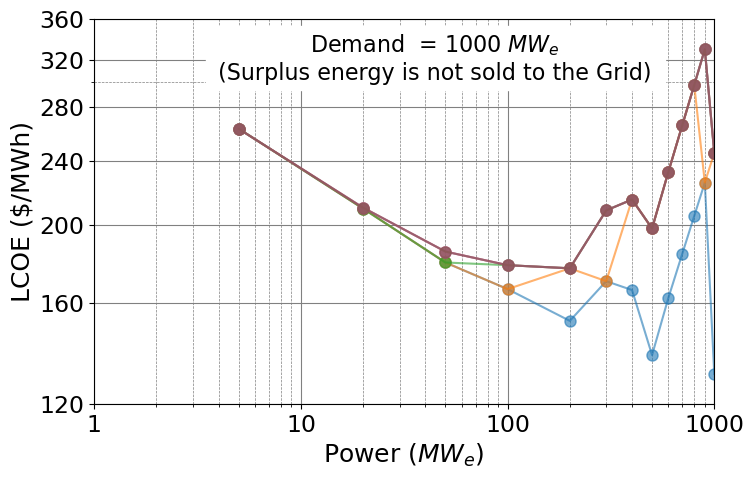

In [52]:
tot_demand_list = [1000]
tot_lcoe_no_sell_lists = [  demand_tot_lcoe_no_sell_list_1000 ] #,\
    # demand_tot_lcoe_no_sell_list_3000, demand_tot_lcoe_no_sell_list_6000]

for i in range(len(tot_demand_list )):
    fig = plt.figure(figsize=(8, 5))
    plt.title( f"Demand  = {tot_demand_list[i]} $MW_e$ \n (Surplus energy is not sold to the Grid) ",  fontsize=16,  x=0.55, y=0.82, backgroundcolor='white') 
    lcoe_no_sell_list = tot_lcoe_no_sell_lists[i]
    for k in range(len(min_capacity_factor_criteria_list)) :
        lcoe_no_sell_k = lcoe_no_sell_list[k]
        if min_capacity_factor_criteria_list[k] == "Baseline":
            plt.plot(power_list ,lcoe_no_sell_k  , '-o' , markersize = 8,  alpha=0.6 ,label = "Baseline")
        else: 
            plt.plot(power_list , lcoe_no_sell_k , '-o' , markersize = 8,  alpha=0.6 ,label = f"Target Daily Agg. Capacity Factor = { min_capacity_factor_criteria_list[k]}")
           
        plt.yscale('log')
        plt.xscale('log')
    if tot_demand_list[i] == 500:
        plt.legend(bbox_to_anchor=(0.5, 1.5), loc='upper center', fontsize=17 , ncol=3)

    plt.grid(which='major', color='grey', linewidth=0.8)
    plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
    plt.minorticks_on() 
     
    plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    
    plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.gca().xaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    
    # setting the ticks
    ticks_min = 40 * np.floor(min(np.concatenate(lcoe_no_sell_list))/40)
    ticks_max = 40 * np.ceil(max(np.concatenate(lcoe_no_sell_list))/40)
    
    ticks_list = np.linspace(ticks_min , ticks_max , 1 +  int((ticks_max - ticks_min)/40)  )    # plt.yticks( ticks_list)
    plt.yticks( ticks_list)
    plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    plt.gca().xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
       
    plt.xlabel('Power ($MW_e$)', fontsize=18)
    plt.ylabel('LCOE ($/MWh)', fontsize=18) 
    plt.xlim( 1, 1000)
    plt.yticks(fontsize=17)
    plt.xticks(fontsize=17) 
    plt.savefig(f'LCOE_{tot_demand}.png', bbox_inches='tight')
    plt.show()

Plot LCOE with grid export

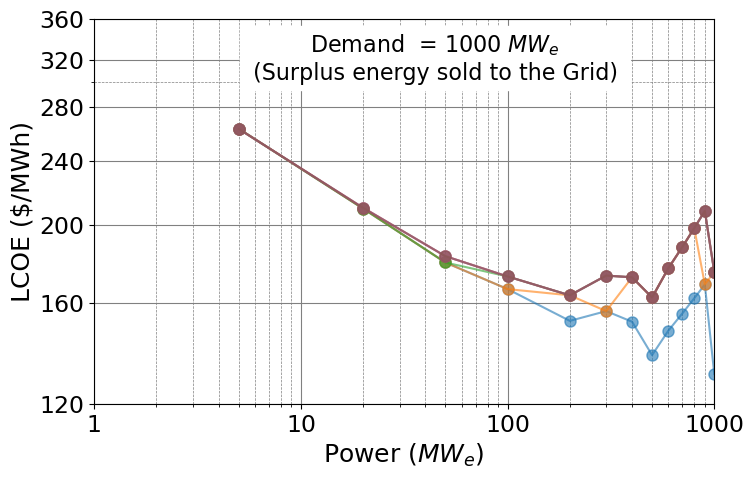

In [53]:
 
tot_lcoe_sell_lists = [  demand_tot_lcoe_sell_list_1000]
for i in range(len(tot_demand_list )):
    fig = plt.figure(figsize=(8, 5))
    plt.title( f"Demand  = {tot_demand_list[i]} $MW_e$ \n (Surplus energy sold to the Grid) ",  fontsize=16,  x=0.55, y=0.82, backgroundcolor='white') 
    lcoe_sell_list = tot_lcoe_sell_lists[i]
    for k in range(len(min_capacity_factor_criteria_list)) :
        lcoe_sell_k = lcoe_sell_list[k]
        if min_capacity_factor_criteria_list[k] == "Baseline":
            plt.plot(power_list ,lcoe_sell_k  , '-o' , markersize = 8,  alpha=0.6 ,label = "Baseline")
        else: 
            plt.plot(power_list , lcoe_sell_k , '-o' , markersize = 8,  alpha=0.6 ,label = f"Target Daily Agg. Capacity Factor = { min_capacity_factor_criteria_list[k]}")
           
        plt.yscale('log')
        plt.xscale('log')
    if tot_demand_list[i] == 500:
        plt.legend(bbox_to_anchor=(0.5, 1.5), loc='upper center', fontsize=17 , ncol=3)

    plt.grid(which='major', color='grey', linewidth=0.8)
    plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
    plt.minorticks_on() 
     
    plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    
    plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.gca().xaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    
    # setting the ticks
    ticks_min = 40 * np.floor(min(np.concatenate(lcoe_no_sell_list))/40)
    ticks_max = 40 * np.ceil(max(np.concatenate(lcoe_no_sell_list))/40)
    
    ticks_list = np.linspace(ticks_min , ticks_max , 1 +  int((ticks_max - ticks_min)/40)  )    # plt.yticks( ticks_list)
    plt.yticks( ticks_list)
    plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    plt.gca().xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
       
    plt.xlabel('Power ($MW_e$)', fontsize=18)
    plt.ylabel('LCOE ($/MWh)', fontsize=18) 
    plt.xlim( 1, 1000)
    plt.yticks(fontsize=17)
    plt.xticks(fontsize=17) 
    plt.savefig(f'LCOE_Selling{tot_demand}.png', bbox_inches='tight')
    plt.show()
